# Feature Analysis: Road Tyre Noise

This notebook analyzes sound-related features from road tyre noise measurements.
We focus on:
- **NAWSSound**: Near-field acoustic wave sensor sound measurements
- **mic_iso**: ISO pass-by noise microphone measurements
- **SIS sensors**: Leading/Trailing edge measurements (Ch_1-4_labV12)

Key analysis techniques:
- Time-domain visualization
- Frequency spectrum analysis
- MFCC (Mel-Frequency Cepstral Coefficients) transformations
- Spectrograms

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import re
import warnings
from pathlib import Path

import h5py
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq

from roar import (
    ALL_VEHICLES,
    DATA_DIR,
    EXTRAS_DIR,
    VEHICLE_CLEAN_NAMES,
    VEHICLE_COLORS,
)

warnings.filterwarnings("ignore")

# Set style for clean, modern plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 100

## 1. Load and Explore Sound-Related Channels

Based on `all_measurement_channels name.csv`, the relevant sound features are:
- **NAWSSound**: NAWS (Near-field Acoustic Wave Sensor) sound measurement
- **mic_iso**: ISO pass-by noise microphone (Mikrofon - Vorbeifahrtgeräusch)
- **Ch_1_labV12 (TrailK1)**: SIS Trailing Edge K1
- **Ch_2_labV12 (TrailK2)**: SIS Trailing Edge K2
- **Ch_3_labV12 (LeadK1)**: SIS Leading Edge K1
- **Ch_4_labV12 (LeadK2)**: SIS Leading Edge K2

In [3]:
# Load the channel information
all_channel_names = pl.read_csv(EXTRAS_DIR / "all_measurement_channels name.csv")
all_channel_names = all_channel_names.with_columns(
    pl.col("vehicle")
    .str.replace(" ", "")
    .str.split(",")
    .replace(VEHICLE_CLEAN_NAMES)
    .replace({tuple(["alle"]): ALL_VEHICLES}),
    pl.col("relevance").cast(pl.Categorical),
)

# Filter for sound-related channels (relevance = 'ja')
sound_channels = all_channel_names.filter(
    (pl.col("relevance") == "ja")
    & (pl.col("channel_name").str.contains("(?i)sound|mic|Ch_[1-4]_labV12"))
)
print("Sound-related channels:")
sound_channels

Sound-related channels:


description,channel_name,synonym_1,synonym_2,vehicle,relevance
str,str,str,str,list[str],cat
"""SIS - Trailing Edge - K1""","""Ch_1_labV12""","""TrailK1""",null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""
"""SIS - Trailing Edge - K2""","""Ch_2_labV12""","""TrailK2""",null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""
"""SIS - Leading Edge - K1""","""Ch_3_labV12""","""LeadK1""",null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""
"""SIS - Leading Edge - K2""","""Ch_4_labV12""","""LeadK2""",null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""
"""NAWS""","""NAWSSound""",null,null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""
"""Mikrofon - Vorbeifahrtger�usch""","""mic_iso""",null,null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""


In [4]:
# List all h5 files in the data directory
h5_files = [p for p in DATA_DIR.rglob("*.h5") if "HDF_Test_Export" not in str(p)]

files_df = pl.DataFrame(
    {
        "file_path": [str(f) for f in h5_files],
        "stem": [f.stem for f in h5_files],
        "track_ID": [int(file.parent.parent.parent.name) for file in h5_files],
        "tyre_ID": [int(re.search(r"Tyre\s*(\d+)", s.parent.name).group(1)) for s in h5_files],
        "vehicle": [file.parent.parent.name for file in h5_files],
    }
)

print(f"Found {len(files_df)} measurement files")
files_df.head(10)

Found 204 measurement files


file_path,stem,track_ID,tyre_ID,vehicle
str,str,i64,i64,str
"""/Users/moritzfeik/Developer/RO…","""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""b50_ID4_RainSport5_ikaISO_2pt6…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""b50_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""ID4_RainSport5_ikaISO_3pt1_vr4…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""ID4_RainSport5_ikaISO_3pt1_vr4…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""ID4_RainSport5_ikaISO_3pt1_vr1…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""b35_ID4_RainSport5_ikaISO_2pt6…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""ID4_RainSport5_ikaISO_2pt6_vr5…",259,3,"""01 VW ID4"""


In [5]:
# Helper functions to load sound data from H5 files
def load_h5_dataset(file_path: str, dataset_name: str):
    """Load a specific dataset from an H5 file."""
    with h5py.File(file_path, "r") as f:
        if dataset_name in f:
            data = f[dataset_name][:]
            # Flatten if 2D with single row/column
            if data.ndim == 2:
                if data.shape[0] == 1:
                    data = data.flatten()
                elif data.shape[1] == 1:
                    data = data.flatten()
            sample_rate = f[dataset_name].attrs.get("sample_rate", None)
            if isinstance(sample_rate, np.ndarray):
                sample_rate = sample_rate.item()
            return data, sample_rate
    return None, None


def get_available_sound_channels(file_path: str):
    """Get list of sound-related channels available in the H5 file."""
    sound_channel_patterns = [
        "NAWSSound",
        "mic_iso",
        "mic_2m",
        "Ch_1_labV12",
        "Ch_2_labV12",
        "Ch_3_labV12",
        "Ch_4_labV12",
    ]
    available = []
    with h5py.File(file_path, "r") as f:

        def check_dataset(name, obj):
            if isinstance(obj, h5py.Dataset):
                for pattern in sound_channel_patterns:
                    if pattern in name:
                        sample_rate = obj.attrs.get("sample_rate", None)
                        if isinstance(sample_rate, np.ndarray):
                            sample_rate = sample_rate.item()
                        available.append(
                            {
                                "name": name,
                                "shape": obj.shape,
                                "sample_rate": sample_rate,
                                "dtype": str(obj.dtype),
                            }
                        )
                        break

        f.visititems(check_dataset)
    return available


# Check what sound channels are available in the first file
sample_file = files_df["file_path"][0]
print(f"Checking sound channels in: {Path(sample_file).name}\n")
available_channels = get_available_sound_channels(sample_file)
for ch in available_channels:
    print(
        f"  {ch['name']}: shape={ch['shape']}, sample_rate={ch['sample_rate']} Hz, dtype={ch['dtype']}"
    )

Checking sound channels in: b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-55-07.h5

  NAWSSound: shape=(1, 231392), sample_rate=32000.0 Hz, dtype=float64


In [6]:
# Check which sound channels are available for each vehicle
print("Sound channels available per vehicle:\n")
for vehicle in files_df["vehicle"].unique():
    vehicle_files_sample = files_df.filter(pl.col("vehicle") == vehicle)["file_path"][:2]
    print(f"{vehicle}:")
    for fp in vehicle_files_sample:
        channels = get_available_sound_channels(fp)
        channel_names = [c["name"] for c in channels]
        print(f"  {Path(fp).name[:50]}...")
        print(f"    Channels: {channel_names}")
    print()

Sound channels available per vehicle:

03 Porsche Taycan:
  track211_Taycan_tyre10_meas6_2p5_1_2025-09-23_17-1...
    Channels: ['Ch_1_labV12', 'Ch_2_labV12', 'Ch_3_labV12', 'Ch_4_labV12', 'NAWSSound', 'mic_2m', 'mic_iso']
  track211_Taycan_tyre10_meas2_2p5_1_2025-09-23_17-0...
    Channels: ['Ch_1_labV12', 'Ch_2_labV12', 'Ch_3_labV12', 'Ch_4_labV12', 'NAWSSound', 'mic_2m', 'mic_iso']

02 Audi Q8:
  track211_Q8 e-tron_tyre12_meas3_2p5_1_2025-08-15_1...
    Channels: ['Ch_1_labV12', 'Ch_2_labV12', 'Ch_3_labV12', 'Ch_4_labV12', 'NAWSSound', 'mic_2m', 'mic_iso']
  track211_Q8 e-tron_tyre12_meas2_2p5_1_2025-08-15_1...
    Channels: ['Ch_1_labV12', 'Ch_2_labV12', 'Ch_3_labV12', 'Ch_4_labV12', 'NAWSSound', 'mic_2m', 'mic_iso']

01 VW ID4:
  b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-...
    Channels: ['NAWSSound']
  b50_ID4_RainSport5_ikaISO_2pt6_vr50_2025-07-11_10-...
    Channels: ['NAWSSound']

04 VW eGolf:
  track211_E-Golf_tyre13_meas3_2p5_1_2025-09-26_14-5...
    Channels: ['Ch_

## 2. Time-Domain Analysis

Let's visualize the raw sound signals in the time domain to understand their characteristics.

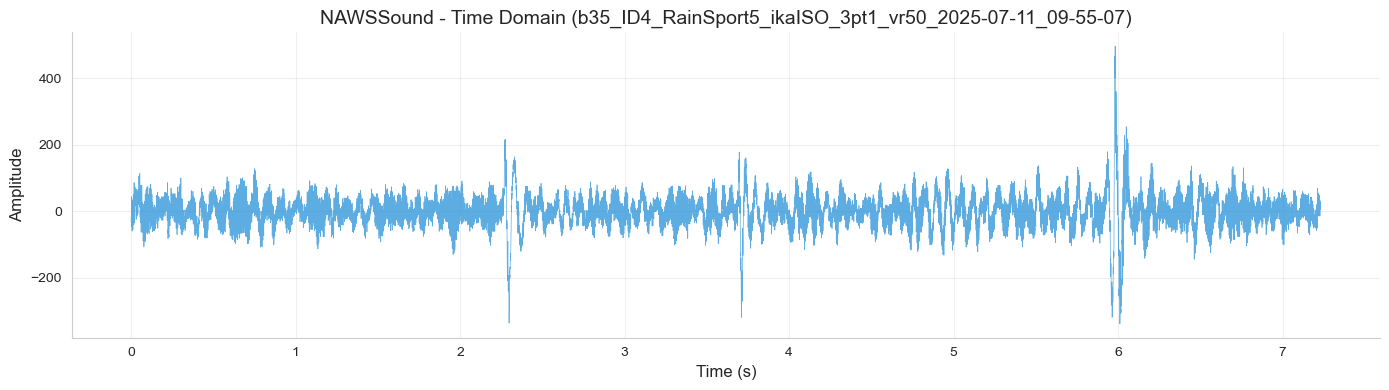

In [7]:
def plot_time_domain(file_path: str, channel_name: str, title_suffix: str = ""):
    """Plot time-domain signal for a given channel."""
    data, sample_rate = load_h5_dataset(file_path, channel_name)

    if data is None:
        print(f"Channel {channel_name} not found in file")
        return None

    # Create time axis
    if sample_rate:
        time = np.arange(len(data)) / sample_rate
        xlabel = "Time (s)"
    else:
        time = np.arange(len(data))
        xlabel = "Sample"

    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(time, data, linewidth=0.5, color="#3498db", alpha=0.8)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("Amplitude", fontsize=12)
    ax.set_title(f"{channel_name} - Time Domain {title_suffix}", fontsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

    return fig, data, sample_rate


# Plot time domain for available sound channels
sample_file = files_df["file_path"][0]
file_info = Path(sample_file).stem

for ch in available_channels[:4]:  # Plot first 4 channels
    fig, data, sr = plot_time_domain(sample_file, ch["name"], f"({file_info})")
    plt.show()

## 3. Frequency Spectrum Analysis (FFT)

Analyze the frequency content of tyre noise signals using Fast Fourier Transform.

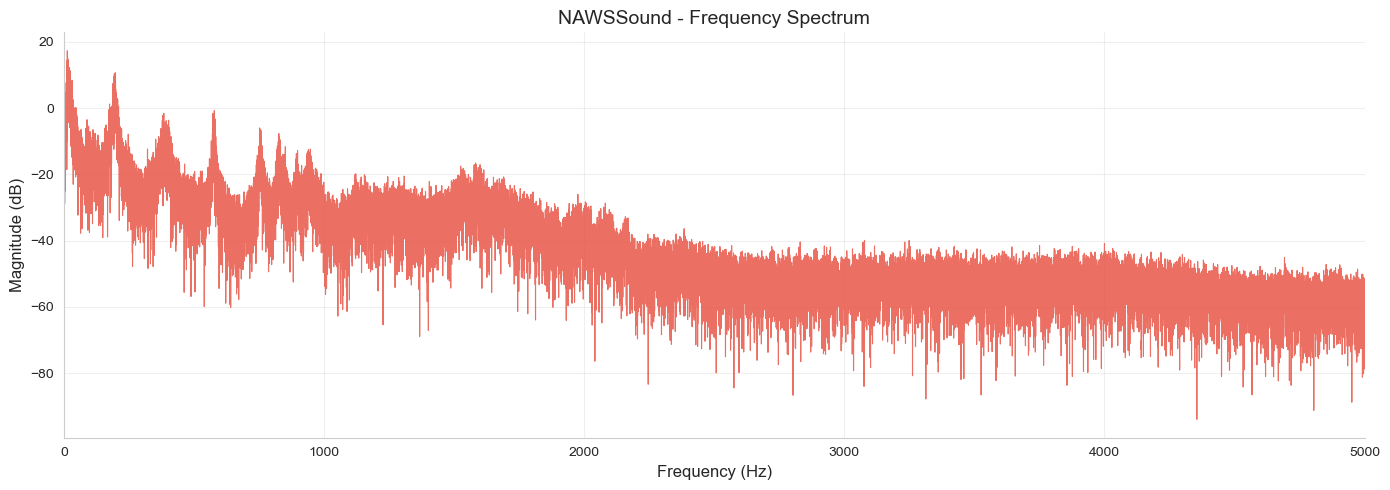

In [8]:
def compute_fft_spectrum(data: np.ndarray, sample_rate: float):
    """Compute FFT spectrum of the signal."""
    n = len(data)
    # Apply window to reduce spectral leakage
    window = signal.windows.hann(n)
    windowed_data = data * window

    # Compute FFT
    yf = fft(windowed_data)
    xf = fftfreq(n, 1 / sample_rate)[: n // 2]

    # Convert to magnitude in dB
    magnitude = 2.0 / n * np.abs(yf[0 : n // 2])
    magnitude_db = 20 * np.log10(magnitude + 1e-10)  # Add small value to avoid log(0)

    return xf, magnitude_db


def plot_frequency_spectrum(file_path: str, channel_name: str, max_freq: float = None):
    """Plot frequency spectrum for a given channel."""
    data, sample_rate = load_h5_dataset(file_path, channel_name)

    if data is None or sample_rate is None:
        print(f"Cannot compute spectrum for {channel_name}")
        return None

    freq, magnitude_db = compute_fft_spectrum(data, sample_rate)

    if max_freq is None:
        max_freq = sample_rate / 2  # Nyquist frequency

    # Filter to max frequency
    mask = freq <= max_freq
    freq = freq[mask]
    magnitude_db = magnitude_db[mask]

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(freq, magnitude_db, linewidth=0.8, color="#e74c3c", alpha=0.8)
    ax.set_xlabel("Frequency (Hz)", fontsize=12)
    ax.set_ylabel("Magnitude (dB)", fontsize=12)
    ax.set_title(f"{channel_name} - Frequency Spectrum", fontsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, max_freq])
    plt.tight_layout()

    return fig


# Plot frequency spectra for sound channels (limit to 5kHz for tyre noise)
sample_file = files_df["file_path"][0]

for ch in available_channels[:4]:
    if ch["sample_rate"]:
        fig = plot_frequency_spectrum(sample_file, ch["name"], max_freq=5000)
        plt.show()

## 4. Spectrogram Analysis

Spectrograms show how the frequency content of tyre noise changes over time, which is crucial for understanding dynamic noise patterns.

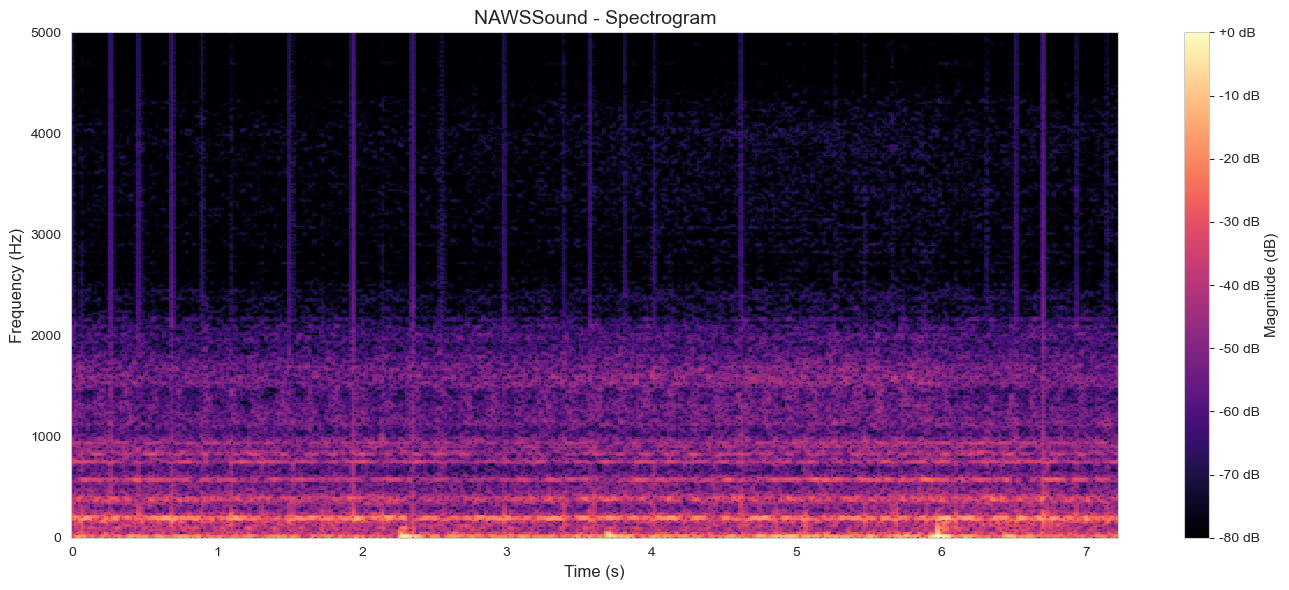

In [9]:
def plot_spectrogram(
    file_path: str,
    channel_name: str,
    max_freq: float = 5000,
    n_fft: int = 2048,
    hop_length: int = 512,
):
    """Plot spectrogram for a given channel using librosa."""
    data, sample_rate = load_h5_dataset(file_path, channel_name)

    if data is None or sample_rate is None:
        print(f"Cannot compute spectrogram for {channel_name}")
        return None

    # Ensure data is float32
    data = data.astype(np.float32)

    # Compute Short-Time Fourier Transform
    stft = librosa.stft(data, n_fft=n_fft, hop_length=hop_length)
    spectrogram_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    fig, ax = plt.subplots(figsize=(14, 6))

    img = librosa.display.specshow(
        spectrogram_db,
        sr=sample_rate,
        hop_length=hop_length,
        x_axis="time",
        y_axis="hz",
        ax=ax,
        cmap="magma",
    )

    ax.set_ylim([0, max_freq])
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Frequency (Hz)", fontsize=12)
    ax.set_title(f"{channel_name} - Spectrogram", fontsize=14)

    cbar = fig.colorbar(img, ax=ax, format="%+2.0f dB")
    cbar.set_label("Magnitude (dB)", fontsize=11)

    plt.tight_layout()
    return fig


# Plot spectrograms for sound channels
sample_file = files_df["file_path"][0]

for ch in available_channels[:4]:
    if ch["sample_rate"]:
        fig = plot_spectrogram(sample_file, ch["name"], max_freq=5000)
        plt.show()

## 5. MFCC (Mel-Frequency Cepstral Coefficients) Analysis

MFCCs are widely used for audio feature extraction. They represent the short-term power spectrum of sound on a mel scale, which approximates human auditory perception. This is particularly useful for:
- Characterizing tyre noise patterns
- Comparing noise signatures across different tyres/vehicles
- Feature extraction for machine learning models

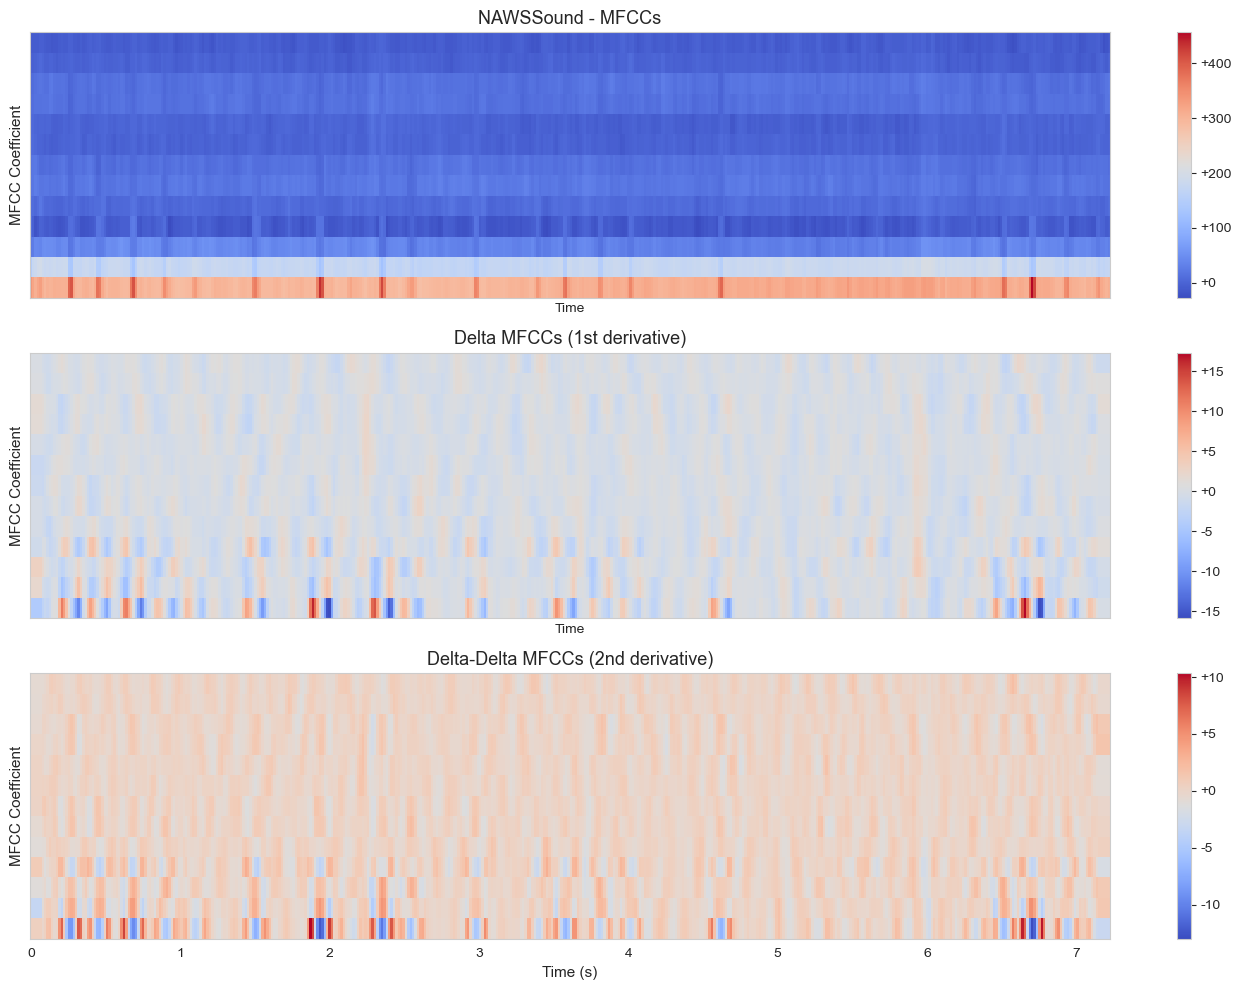

In [10]:
def compute_mfcc(
    data: np.ndarray, sample_rate: float, n_mfcc: int = 13, n_fft: int = 2048, hop_length: int = 512
):
    """Compute MFCC features for audio data."""
    data = data.astype(np.float32)

    mfccs = librosa.feature.mfcc(
        y=data, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length
    )

    # Also compute delta and delta-delta MFCCs for more features
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)

    return mfccs, mfcc_delta, mfcc_delta2


def plot_mfcc(file_path: str, channel_name: str, n_mfcc: int = 13):
    """Plot MFCC features for a given channel."""
    data, sample_rate = load_h5_dataset(file_path, channel_name)

    if data is None or sample_rate is None:
        print(f"Cannot compute MFCC for {channel_name}")
        return None

    mfccs, mfcc_delta, mfcc_delta2 = compute_mfcc(data, sample_rate, n_mfcc=n_mfcc)

    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    # Plot MFCCs
    img1 = librosa.display.specshow(
        mfccs, sr=sample_rate, x_axis="time", ax=axes[0], cmap="coolwarm"
    )
    axes[0].set_ylabel("MFCC Coefficient", fontsize=11)
    axes[0].set_title(f"{channel_name} - MFCCs", fontsize=13)
    fig.colorbar(img1, ax=axes[0], format="%+2.0f")

    # Plot Delta MFCCs
    img2 = librosa.display.specshow(
        mfcc_delta, sr=sample_rate, x_axis="time", ax=axes[1], cmap="coolwarm"
    )
    axes[1].set_ylabel("MFCC Coefficient", fontsize=11)
    axes[1].set_title("Delta MFCCs (1st derivative)", fontsize=13)
    fig.colorbar(img2, ax=axes[1], format="%+2.0f")

    # Plot Delta-Delta MFCCs
    img3 = librosa.display.specshow(
        mfcc_delta2, sr=sample_rate, x_axis="time", ax=axes[2], cmap="coolwarm"
    )
    axes[2].set_ylabel("MFCC Coefficient", fontsize=11)
    axes[2].set_xlabel("Time (s)", fontsize=11)
    axes[2].set_title("Delta-Delta MFCCs (2nd derivative)", fontsize=13)
    fig.colorbar(img3, ax=axes[2], format="%+2.0f")

    plt.tight_layout()
    return fig, mfccs


# Plot MFCCs for sound channels
sample_file = files_df["file_path"][0]

for ch in available_channels[:2]:  # Show first 2 channels for brevity
    if ch["sample_rate"]:
        fig, mfccs = plot_mfcc(sample_file, ch["name"])
        plt.show()

## 6. Mel Spectrogram

The Mel spectrogram applies a perceptually-motivated mel scale to the frequency axis, which better represents how humans perceive sound.

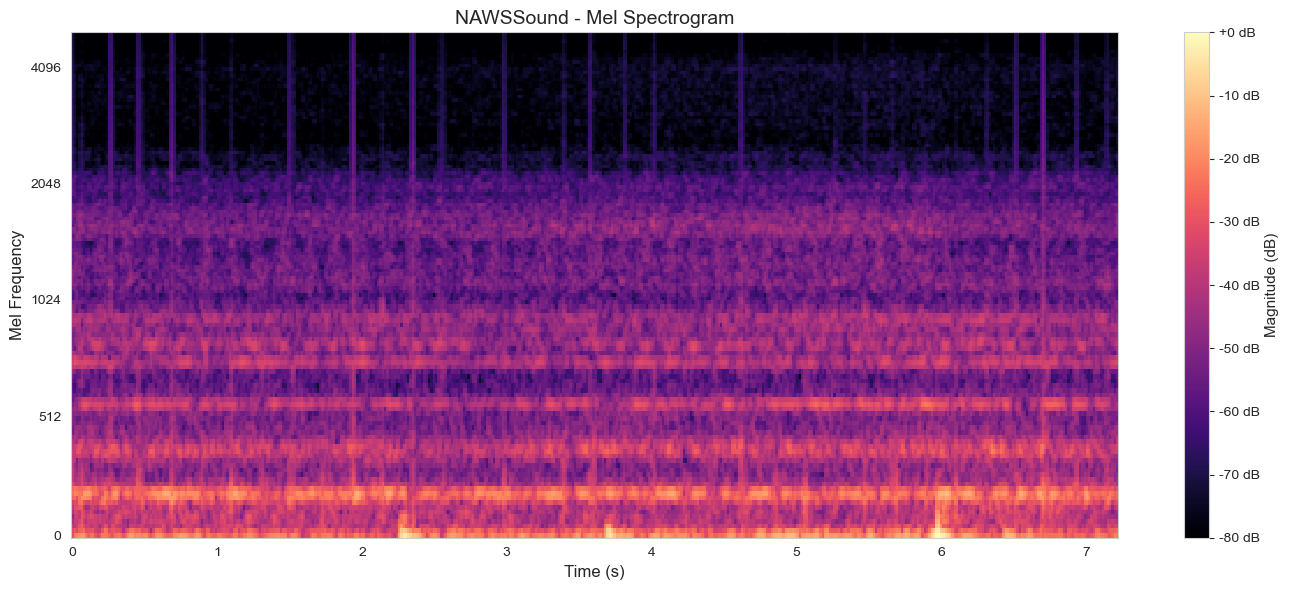

In [11]:
def plot_mel_spectrogram(
    file_path: str,
    channel_name: str,
    n_mels: int = 128,
    n_fft: int = 2048,
    hop_length: int = 512,
    fmax: float = 5000,
):
    """Plot Mel spectrogram for a given channel."""
    data, sample_rate = load_h5_dataset(file_path, channel_name)

    if data is None or sample_rate is None:
        print(f"Cannot compute Mel spectrogram for {channel_name}")
        return None

    data = data.astype(np.float32)

    # Compute Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=data, sr=sample_rate, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, fmax=fmax
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    fig, ax = plt.subplots(figsize=(14, 6))

    img = librosa.display.specshow(
        mel_spec_db,
        sr=sample_rate,
        hop_length=hop_length,
        x_axis="time",
        y_axis="mel",
        ax=ax,
        cmap="magma",
        fmax=fmax,
    )

    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Mel Frequency", fontsize=12)
    ax.set_title(f"{channel_name} - Mel Spectrogram", fontsize=14)

    cbar = fig.colorbar(img, ax=ax, format="%+2.0f dB")
    cbar.set_label("Magnitude (dB)", fontsize=11)

    plt.tight_layout()
    return fig, mel_spec_db


# Plot Mel spectrograms
sample_file = files_df["file_path"][0]

for ch in available_channels[:2]:
    if ch["sample_rate"]:
        fig, mel_spec = plot_mel_spectrogram(sample_file, ch["name"])
        plt.show()

## 7. Comparative Analysis Across Vehicles and Tyres

Compare the sound characteristics across different vehicles and tyres to understand how they affect road tyre noise.

In [12]:
def extract_audio_features(file_path: str, channel_name: str):
    """Extract a comprehensive set of audio features for comparison."""
    data, sample_rate = load_h5_dataset(file_path, channel_name)

    if data is None or sample_rate is None:
        return None

    data = data.astype(np.float32)

    features = {}

    # Basic statistics
    features["rms"] = np.sqrt(np.mean(data**2))
    features["peak"] = np.max(np.abs(data))
    features["crest_factor"] = features["peak"] / features["rms"] if features["rms"] > 0 else 0

    # Zero crossing rate (indicator of noise vs tonal content)
    features["zcr_mean"] = np.mean(librosa.feature.zero_crossing_rate(data))

    # Spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sample_rate)
    features["spectral_centroid_mean"] = np.mean(spectral_centroid)
    features["spectral_centroid_std"] = np.std(spectral_centroid)

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sample_rate)
    features["spectral_bandwidth_mean"] = np.mean(spectral_bandwidth)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=data, sr=sample_rate)
    features["spectral_rolloff_mean"] = np.mean(spectral_rolloff)

    # Spectral flatness (measure of noise-like vs tonal)
    spectral_flatness = librosa.feature.spectral_flatness(y=data)
    features["spectral_flatness_mean"] = np.mean(spectral_flatness)

    # MFCC statistics
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)
    for i in range(13):
        features[f"mfcc_{i + 1}_mean"] = np.mean(mfccs[i])
        features[f"mfcc_{i + 1}_std"] = np.std(mfccs[i])

    return features


# Select one file per vehicle for comparison
vehicle_files = {}
for vehicle in files_df["vehicle"].unique():
    vehicle_file = files_df.filter(pl.col("vehicle") == vehicle)["file_path"][0]
    vehicle_files[vehicle] = vehicle_file

print("Selected files for comparison:")
for v, f in vehicle_files.items():
    print(f"  {v}: {Path(f).name}")

Selected files for comparison:
  01 VW ID4: b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-55-07.h5
  04 VW eGolf: track211_E-Golf_tyre13_meas3_2p5_1_2025-09-26_14-53-31.h5
  02 Audi Q8: track211_Q8 e-tron_tyre12_meas3_2p5_1_2025-08-15_12-50-11.h5
  03 Porsche Taycan: track211_Taycan_tyre10_meas6_2p5_1_2025-09-23_17-14-56.h5


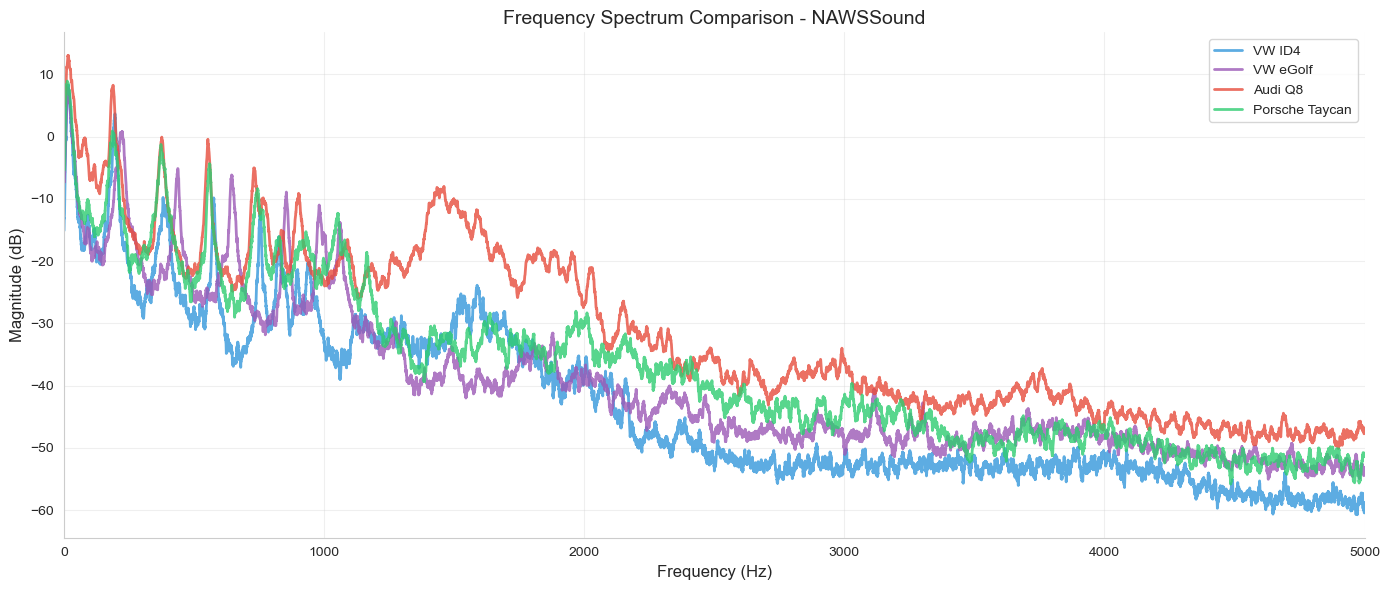

In [13]:
# Extract features for each vehicle and compare
def compare_vehicles_spectrum(vehicle_files: dict, channel_name: str, max_freq: float = 5000):
    """Compare frequency spectra across different vehicles."""
    fig, ax = plt.subplots(figsize=(14, 6))

    for vehicle, file_path in vehicle_files.items():
        data, sample_rate = load_h5_dataset(file_path, channel_name)
        if data is None or sample_rate is None:
            continue

        freq, magnitude_db = compute_fft_spectrum(data, sample_rate)

        # Filter and smooth for better visualization
        mask = freq <= max_freq
        freq = freq[mask]
        magnitude_db = magnitude_db[mask]

        # Apply smoothing
        from scipy.ndimage import uniform_filter1d

        magnitude_smooth = uniform_filter1d(magnitude_db, size=50)

        color = VEHICLE_COLORS.get(vehicle, "#95a5a6")
        label = vehicle.split(" ", 1)[1] if " " in vehicle else vehicle
        ax.plot(freq, magnitude_smooth, linewidth=2, color=color, label=label, alpha=0.8)

    ax.set_xlabel("Frequency (Hz)", fontsize=12)
    ax.set_ylabel("Magnitude (dB)", fontsize=12)
    ax.set_title(f"Frequency Spectrum Comparison - {channel_name}", fontsize=14)
    ax.legend(loc="upper right", fontsize=10)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, max_freq])
    plt.tight_layout()

    return fig


# Compare vehicles using the first available sound channel
if available_channels:
    channel_to_compare = available_channels[0]["name"]
    fig = compare_vehicles_spectrum(vehicle_files, channel_to_compare)
    plt.show()

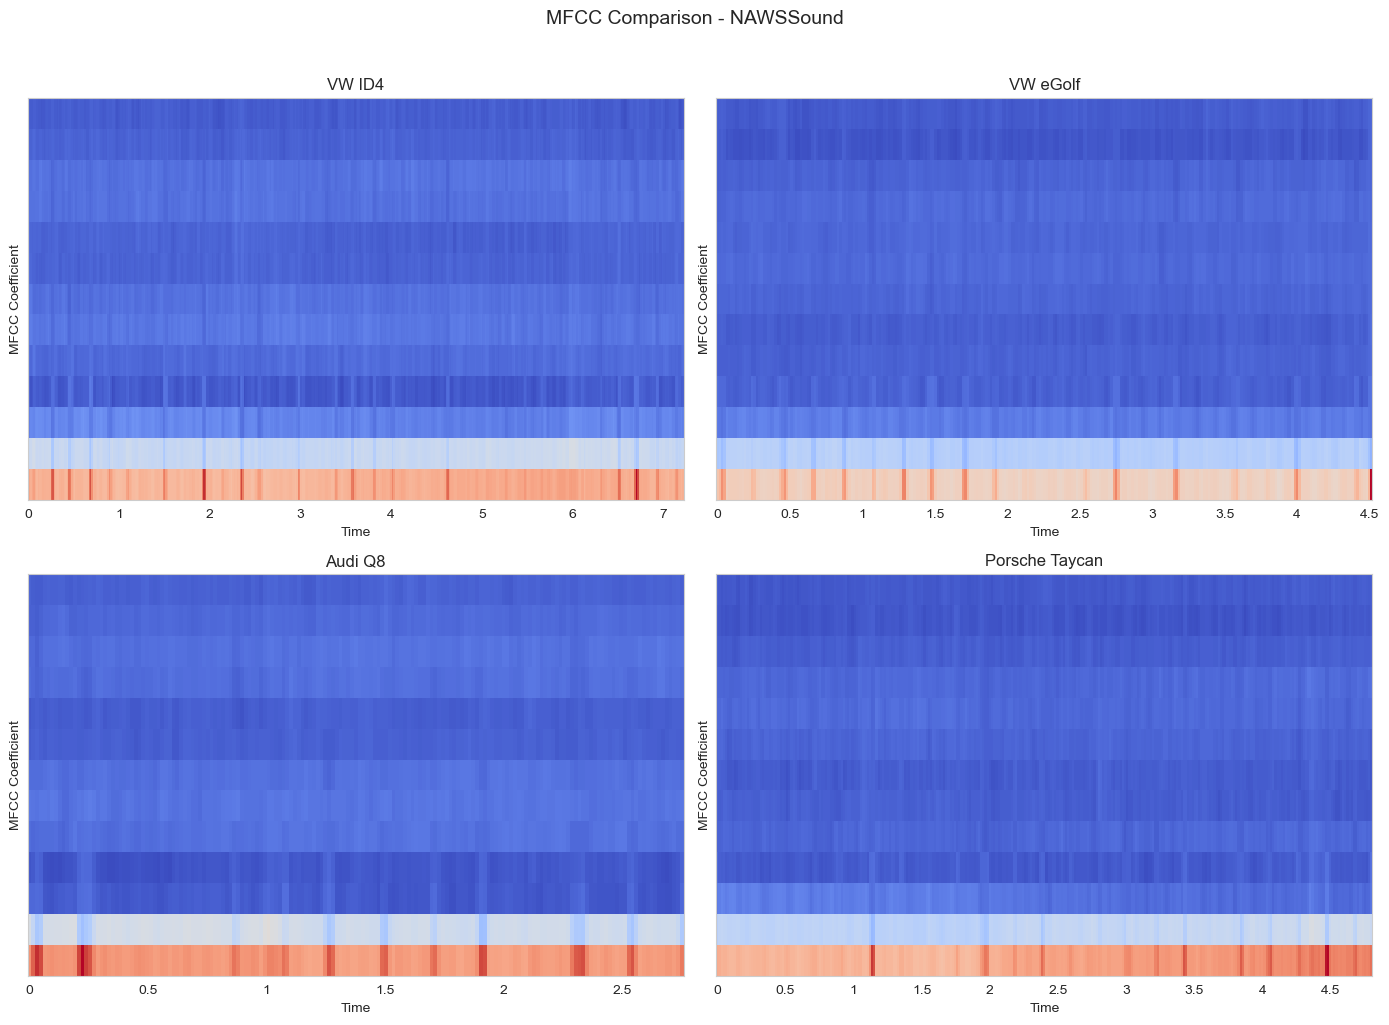

In [ ]:
# Compare MFCCs across vehicles
def compare_mfcc_profiles(vehicle_files: dict, channel_name: str):
    """Compare average MFCC profiles across vehicles."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    mfcc_means = {}

    for idx, (vehicle, file_path) in enumerate(vehicle_files.items()):
        if idx >= 4:  # Limit to 4 vehicles for layout
            break

        data, sample_rate = load_h5_dataset(file_path, channel_name)
        if data is None or sample_rate is None:
            continue

        data = data.astype(np.float32)
        mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)

        label = vehicle.split(" ", 1)[1] if " " in vehicle else vehicle

        # Store mean MFCC for comparison
        mfcc_means[vehicle] = np.mean(mfccs, axis=1)

        # Plot MFCC for each vehicle
        librosa.display.specshow(
            mfccs, sr=sample_rate, x_axis="time", ax=axes[idx], cmap="coolwarm"
        )
        axes[idx].set_title(f"{label}", fontsize=12)
        axes[idx].set_ylabel("MFCC Coefficient")

    plt.suptitle(f"MFCC Comparison - {channel_name}", fontsize=14, y=1.02)
    plt.tight_layout()

    return fig, mfcc_means


if available_channels:
    channel_to_compare = available_channels[0]["name"]
    fig, mfcc_means = compare_mfcc_profiles(vehicle_files, channel_to_compare)
    plt.show()

## 8. Feature Summary Statistics

Extract and visualize key audio features across all measurements for a comprehensive overview.

In [15]:
# Build channel synonym mapping from CSV
def build_channel_synonym_map(channels_df: pl.DataFrame) -> dict:
    """Build a mapping from channel names to their synonyms."""
    synonym_map = {}
    for row in channels_df.iter_rows(named=True):
        channel_name = row.get("channel_name", "")
        if not channel_name:
            continue

        # Build list of all names for this channel (main + synonyms)
        all_names = [channel_name]
        if row.get("synonym_1") and str(row.get("synonym_1")) not in ["", "None"]:
            all_names.append(str(row.get("synonym_1")))
        if row.get("synonym_2") and str(row.get("synonym_2")) not in ["", "None"]:
            all_names.append(str(row.get("synonym_2")))

        # Map each name to all possible names
        for name in all_names:
            synonym_map[name] = all_names

    return synonym_map


# Create the synonym map
CHANNEL_SYNONYMS = build_channel_synonym_map(all_channel_names)

# Show relevant sound channel synonyms
print("Sound channel synonyms from CSV:")
for ch in ["Ch_1_labV12", "Ch_2_labV12", "Ch_3_labV12", "Ch_4_labV12", "NAWSSound", "mic_iso"]:
    if ch in CHANNEL_SYNONYMS:
        print(f"  {ch}: {CHANNEL_SYNONYMS[ch]}")


# Extract features from all files (sample for efficiency)
def extract_features_from_files(
    files_df: pl.DataFrame, channel_pattern: str, max_files: int = 50, synonym_map: dict = None
):
    """Extract audio features from multiple files.

    Uses synonym_map to find equivalent channel names when the primary pattern is not found.
    Only extracts from files that have the specified channel (or its synonyms).
    """
    all_features = []

    # Sample files if too many
    if len(files_df) > max_files:
        sample_df = files_df.sample(n=max_files, seed=42)
    else:
        sample_df = files_df

    # Build list of patterns to search for (main + synonyms)
    patterns_to_try = [channel_pattern]
    if synonym_map and channel_pattern in synonym_map:
        patterns_to_try = synonym_map[channel_pattern]

    print(f"Searching for channel patterns: {patterns_to_try}")

    for row in sample_df.iter_rows(named=True):
        file_path = row["file_path"]

        # Find matching channel - try each pattern in order
        channels = get_available_sound_channels(file_path)
        matching_channel = None

        for pattern in patterns_to_try:
            matching = [c for c in channels if pattern in c["name"]]
            if matching:
                matching_channel = matching[0]["name"]
                break

        if not matching_channel:
            continue

        features = extract_audio_features(file_path, matching_channel)

        if features:
            features["file_path"] = file_path
            features["vehicle"] = row["vehicle"]
            features["tyre_ID"] = row["tyre_ID"]
            features["track_ID"] = row["track_ID"]
            features["channel_used"] = matching_channel
            all_features.append(features)

    return pl.DataFrame(all_features)


# Extract features using NAWSSound - the only channel available for ALL vehicles
print("\nExtracting audio features from files using NAWSSound...")
features_df = extract_features_from_files(
    files_df,
    "NAWSSound",  # Use NAWSSound for fair comparison across all vehicles
    max_files=50,
    synonym_map=CHANNEL_SYNONYMS,
)
print(f"\nExtracted features from {len(features_df)} files")
print(f"Vehicles in features_df: {features_df['vehicle'].unique().to_list()}")
print(
    f"Channels used: {features_df['channel_used'].unique().to_list() if 'channel_used' in features_df.columns else 'N/A'}"
)
features_df.head()

Sound channel synonyms from CSV:
  Ch_1_labV12: ['Ch_1_labV12', 'TrailK1']
  Ch_2_labV12: ['Ch_2_labV12', 'TrailK2']
  Ch_3_labV12: ['Ch_3_labV12', 'LeadK1']
  Ch_4_labV12: ['Ch_4_labV12', 'LeadK2']
  NAWSSound: ['NAWSSound']
  mic_iso: ['mic_iso']

Extracting audio features from files using NAWSSound...
Searching for channel patterns: ['NAWSSound']

Extracted features from 49 files
Vehicles in features_df: ['03 Porsche Taycan', '02 Audi Q8', '04 VW eGolf', '01 VW ID4']
Channels used: ['NAWSSound']

Extracted features from 49 files
Vehicles in features_df: ['03 Porsche Taycan', '02 Audi Q8', '04 VW eGolf', '01 VW ID4']
Channels used: ['NAWSSound']


rms,peak,crest_factor,zcr_mean,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_rolloff_mean,spectral_flatness_mean,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,mfcc_5_std,mfcc_6_mean,mfcc_6_std,mfcc_7_mean,mfcc_7_std,mfcc_8_mean,mfcc_8_std,mfcc_9_mean,mfcc_9_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_12_mean,mfcc_12_std,mfcc_13_mean,mfcc_13_std,file_path,vehicle,tyre_ID,track_ID,channel_used
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,i64,i64,str
40.729969,504.166229,12.378262,0.020992,760.290216,305.542487,1553.249863,1135.139173,0.00042,313.581757,23.303679,181.204498,11.063271,42.35693,7.625542,1.789871,7.797145,0.833849,4.510868,-2.273221,4.495471,5.577747,3.835555,10.5834,4.050914,8.359807,3.702995,11.668988,4.731977,2.294427,4.173761,-14.878482,4.657568,-7.191393,3.971017,"""/Users/moritzfeik/Developer/RO…","""04 VW eGolf""",13,150,"""NAWSSound"""
45.642841,476.93811,10.449352,0.015672,728.974812,339.241504,1564.102556,1161.509901,0.000371,296.509399,31.50038,161.818787,8.886943,48.974434,9.396707,3.67525,7.623394,-0.731942,4.869508,1.584851,4.855405,7.469056,3.984482,10.869092,4.109087,10.844127,4.047472,11.428748,4.028867,0.651905,3.669119,-14.184554,5.450852,-7.606935,4.421096,"""/Users/moritzfeik/Developer/RO…","""04 VW eGolf""",13,211,"""NAWSSound"""
49.200752,542.215942,11.020481,0.01576,749.571965,360.993137,1564.590451,1192.893401,0.000487,315.334991,22.438803,169.96579,10.135712,40.184765,7.044639,0.716222,7.208567,7.652957,4.041654,3.398776,4.074952,-0.886075,4.494012,9.266896,3.798019,16.448696,4.748155,11.382296,4.341441,0.419935,4.204319,-6.76529,4.596125,-4.231278,3.704038,"""/Users/moritzfeik/Developer/RO…","""03 Porsche Taycan""",10,150,"""NAWSSound"""
52.242718,548.117981,10.491758,0.014606,753.330772,363.204511,1578.699868,1205.221861,0.000427,318.37323,24.544212,170.788895,11.222538,36.367329,6.774251,2.596809,7.937316,9.519369,4.539837,1.835628,4.196693,-0.307641,4.588201,10.758002,4.200386,16.063358,5.022644,11.772533,4.292484,1.472863,4.139145,-6.788513,4.655609,-4.146955,3.739964,"""/Users/moritzfeik/Developer/RO…","""03 Porsche Taycan""",10,211,"""NAWSSound"""
40.533634,461.071808,11.375042,0.01973,769.40018,355.192466,1595.042962,1170.738078,0.0005,311.474792,31.341095,173.951935,13.297475,47.160313,11.485977,3.558743,8.389592,-0.638814,4.609688,-1.513175,5.142902,5.45628,4.306844,10.505644,4.055074,9.92509,4.278859,11.130149,4.738106,1.003125,4.127026,-14.094078,5.298133,-7.427775,4.187474,"""/Users/moritzfeik/Developer/RO…","""04 VW eGolf""",13,150,"""NAWSSound"""


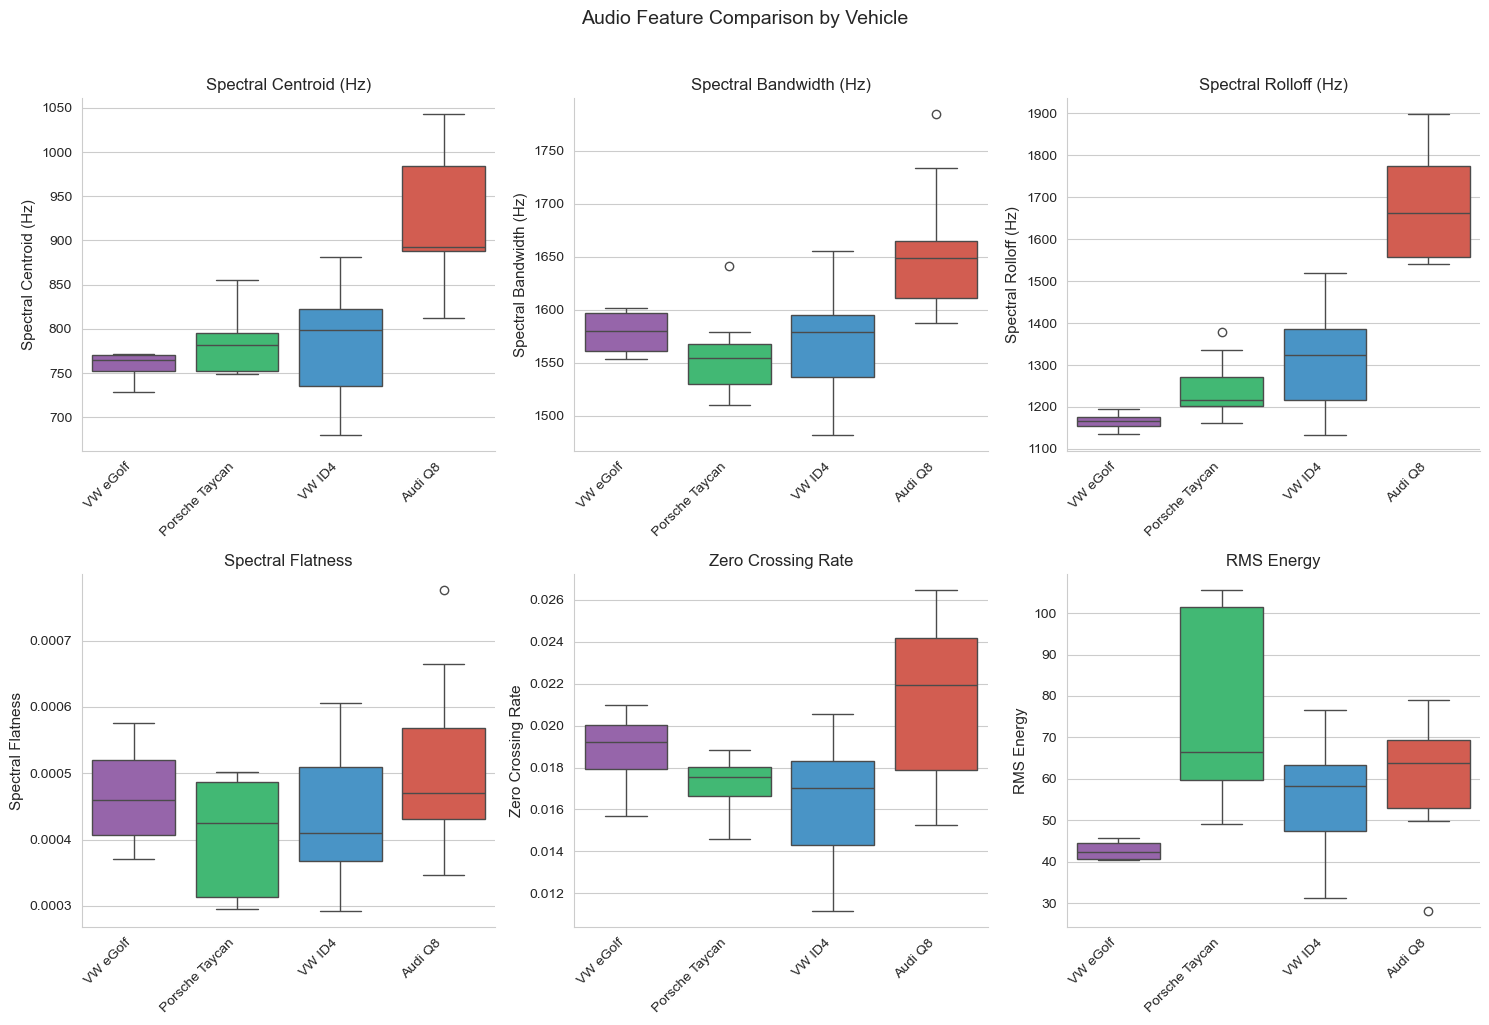

In [16]:
# Visualize feature distributions by vehicle
def plot_feature_comparison(features_df: pl.DataFrame):
    """Plot comparison of key audio features across vehicles."""
    key_features = [
        "spectral_centroid_mean",
        "spectral_bandwidth_mean",
        "spectral_rolloff_mean",
        "spectral_flatness_mean",
        "zcr_mean",
        "rms",
    ]

    feature_labels = {
        "spectral_centroid_mean": "Spectral Centroid (Hz)",
        "spectral_bandwidth_mean": "Spectral Bandwidth (Hz)",
        "spectral_rolloff_mean": "Spectral Rolloff (Hz)",
        "spectral_flatness_mean": "Spectral Flatness",
        "zcr_mean": "Zero Crossing Rate",
        "rms": "RMS Energy",
    }

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    pdf = features_df.to_pandas()

    for idx, feature in enumerate(key_features):
        if feature not in pdf.columns:
            continue

        ax = axes[idx]

        sns.boxplot(data=pdf, x="vehicle", y=feature, palette=VEHICLE_COLORS, ax=ax)

        ax.set_xlabel("")
        ax.set_ylabel(feature_labels.get(feature, feature), fontsize=11)
        ax.set_title(feature_labels.get(feature, feature), fontsize=12)

        # Clean up x-axis labels
        labels = [
            label.get_text().split(" ", 1)[1] if " " in label.get_text() else label.get_text()
            for label in ax.get_xticklabels()
        ]
        ax.set_xticklabels(labels, rotation=45, ha="right")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    plt.suptitle("Audio Feature Comparison by Vehicle", fontsize=14, y=1.02)
    plt.tight_layout()
    return fig


if len(features_df) > 0:
    fig = plot_feature_comparison(features_df)
    plt.show()

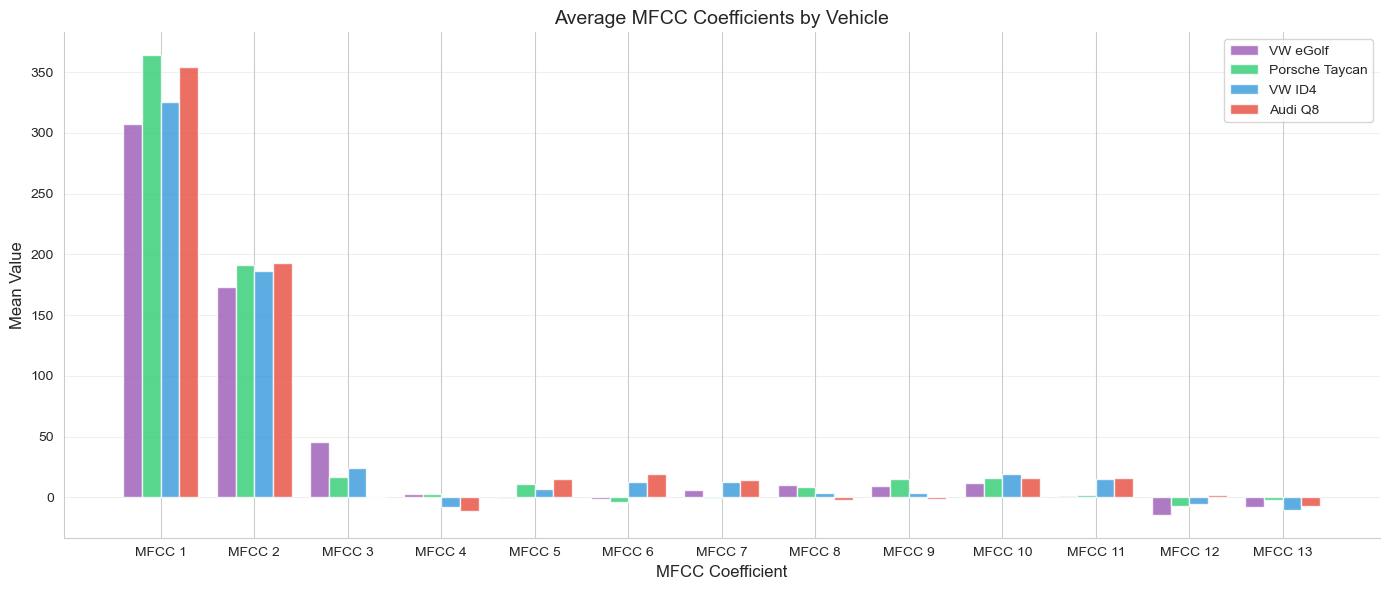

In [17]:
# Plot MFCC feature comparison by vehicle
def plot_mfcc_comparison(features_df: pl.DataFrame):
    """Plot mean MFCC coefficients by vehicle."""
    mfcc_cols = [f"mfcc_{i}_mean" for i in range(1, 14)]

    # Check which columns exist
    existing_cols = [col for col in mfcc_cols if col in features_df.columns]
    if not existing_cols:
        print("No MFCC features available")
        return None

    pdf = features_df.to_pandas()

    fig, ax = plt.subplots(figsize=(14, 6))

    x = np.arange(len(existing_cols))
    width = 0.2

    vehicles = pdf["vehicle"].unique()

    for idx, vehicle in enumerate(vehicles):
        vehicle_data = pdf[pdf["vehicle"] == vehicle]
        mfcc_means = [vehicle_data[col].mean() for col in existing_cols]

        color = VEHICLE_COLORS.get(vehicle, "#95a5a6")
        label = vehicle.split(" ", 1)[1] if " " in vehicle else vehicle

        ax.bar(x + idx * width, mfcc_means, width, label=label, color=color, alpha=0.8)

    ax.set_xlabel("MFCC Coefficient", fontsize=12)
    ax.set_ylabel("Mean Value", fontsize=12)
    ax.set_title("Average MFCC Coefficients by Vehicle", fontsize=14)
    ax.set_xticks(x + width * (len(vehicles) - 1) / 2)
    ax.set_xticklabels([f"MFCC {i}" for i in range(1, len(existing_cols) + 1)])
    ax.legend(loc="upper right", fontsize=10)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    return fig


if len(features_df) > 0:
    fig = plot_mfcc_comparison(features_df)
    plt.show()

## 9. Octave Band Analysis

Octave band analysis is commonly used in acoustics to analyze noise levels across standard frequency bands. This is particularly relevant for tyre noise regulations and characterization.

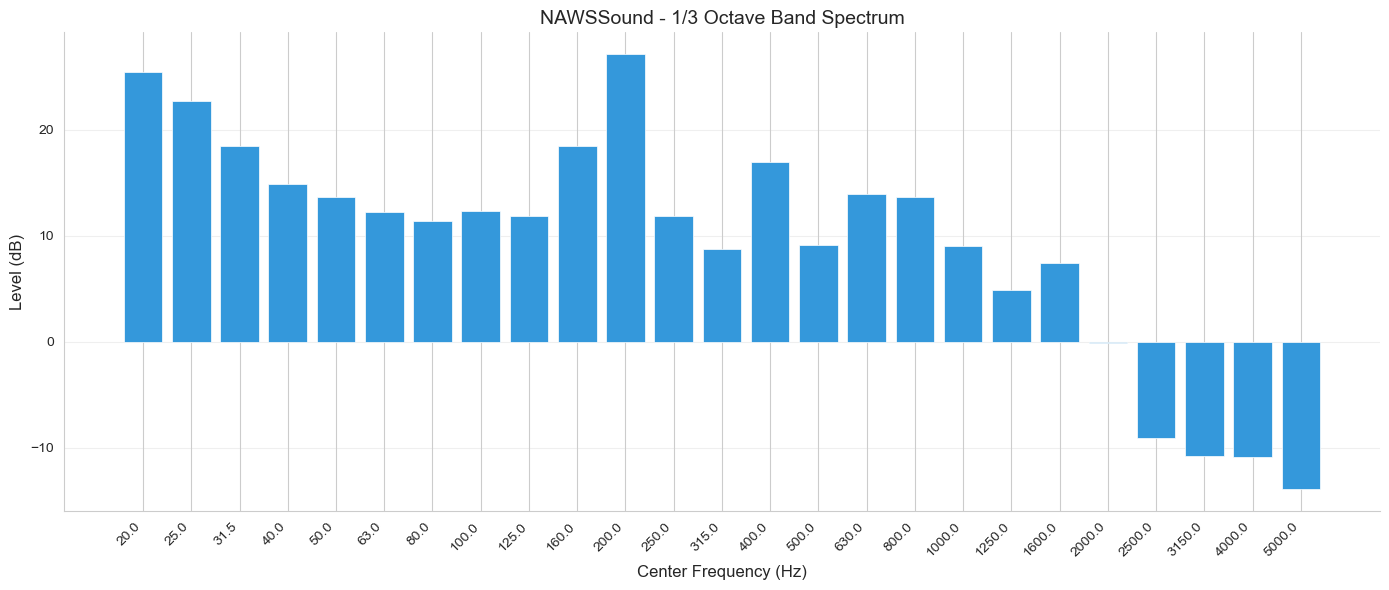

In [18]:
# Standard 1/3 octave band center frequencies (Hz)
OCTAVE_BANDS = [
    20,
    25,
    31.5,
    40,
    50,
    63,
    80,
    100,
    125,
    160,
    200,
    250,
    315,
    400,
    500,
    630,
    800,
    1000,
    1250,
    1600,
    2000,
    2500,
    3150,
    4000,
    5000,
]


def compute_octave_band_levels(data: np.ndarray, sample_rate: float, bands: list = OCTAVE_BANDS):
    """Compute 1/3 octave band levels."""
    band_levels = []

    for fc in bands:
        if fc > sample_rate / 2:
            band_levels.append(np.nan)
            continue

        # 1/3 octave band edges
        f_low = fc / (2 ** (1 / 6))
        f_high = fc * (2 ** (1 / 6))

        # Ensure within Nyquist
        f_high = min(f_high, sample_rate / 2 * 0.99)

        if f_low >= sample_rate / 2:
            band_levels.append(np.nan)
            continue

        # Design bandpass filter
        try:
            sos = signal.butter(4, [f_low, f_high], btype="band", fs=sample_rate, output="sos")
            filtered = signal.sosfilt(sos, data)

            # Compute RMS level in dB
            rms = np.sqrt(np.mean(filtered**2))
            level_db = 20 * np.log10(rms + 1e-10)
            band_levels.append(level_db)
        except Exception:
            band_levels.append(np.nan)

    return np.array(band_levels)


def plot_octave_bands(file_path: str, channel_name: str):
    """Plot 1/3 octave band spectrum."""
    data, sample_rate = load_h5_dataset(file_path, channel_name)

    if data is None or sample_rate is None:
        print(f"Cannot compute octave bands for {channel_name}")
        return None

    levels = compute_octave_band_levels(data, sample_rate)

    fig, ax = plt.subplots(figsize=(14, 6))

    valid_mask = ~np.isnan(levels)
    valid_bands = np.array(OCTAVE_BANDS)[valid_mask]
    valid_levels = levels[valid_mask]

    ax.bar(
        range(len(valid_levels)), valid_levels, color="#3498db", edgecolor="white", linewidth=0.5
    )
    ax.set_xticks(range(len(valid_levels)))
    ax.set_xticklabels([f"{b}" for b in valid_bands], rotation=45, ha="right")
    ax.set_xlabel("Center Frequency (Hz)", fontsize=12)
    ax.set_ylabel("Level (dB)", fontsize=12)
    ax.set_title(f"{channel_name} - 1/3 Octave Band Spectrum", fontsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    return fig


# Plot octave band analysis
sample_file = files_df["file_path"][0]
if available_channels:
    fig = plot_octave_bands(sample_file, available_channels[0]["name"])
    plt.show()

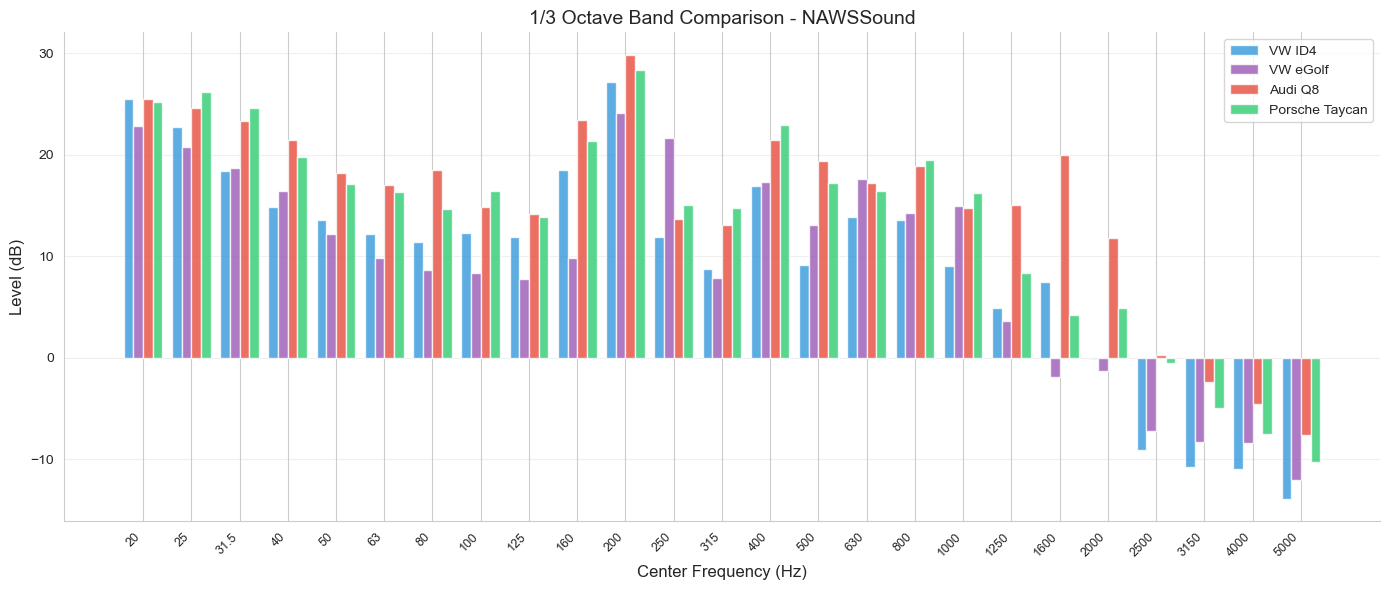

In [19]:
# Compare octave band spectra across vehicles
def compare_octave_bands(vehicle_files: dict, channel_name: str):
    """Compare 1/3 octave band spectra across vehicles."""
    fig, ax = plt.subplots(figsize=(14, 6))

    all_levels = {}

    for vehicle, file_path in vehicle_files.items():
        data, sample_rate = load_h5_dataset(file_path, channel_name)
        if data is None or sample_rate is None:
            continue

        levels = compute_octave_band_levels(data, sample_rate)
        all_levels[vehicle] = levels

    x = np.arange(len(OCTAVE_BANDS))
    width = 0.2

    for idx, (vehicle, levels) in enumerate(all_levels.items()):
        color = VEHICLE_COLORS.get(vehicle, "#95a5a6")
        label = vehicle.split(" ", 1)[1] if " " in vehicle else vehicle

        # Handle NaN values
        valid_levels = np.nan_to_num(levels, nan=-100)
        ax.bar(x + idx * width, valid_levels, width, label=label, color=color, alpha=0.8)

    ax.set_xticks(x + width * (len(all_levels) - 1) / 2)
    ax.set_xticklabels([f"{b}" for b in OCTAVE_BANDS], rotation=45, ha="right", fontsize=9)
    ax.set_xlabel("Center Frequency (Hz)", fontsize=12)
    ax.set_ylabel("Level (dB)", fontsize=12)
    ax.set_title(f"1/3 Octave Band Comparison - {channel_name}", fontsize=14)
    ax.legend(loc="upper right", fontsize=10)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    return fig


if available_channels:
    fig = compare_octave_bands(vehicle_files, available_channels[0]["name"])
    plt.show()

## 10. Feature Correlation Analysis

Analyze correlations between different audio features to understand their relationships and potential redundancies.

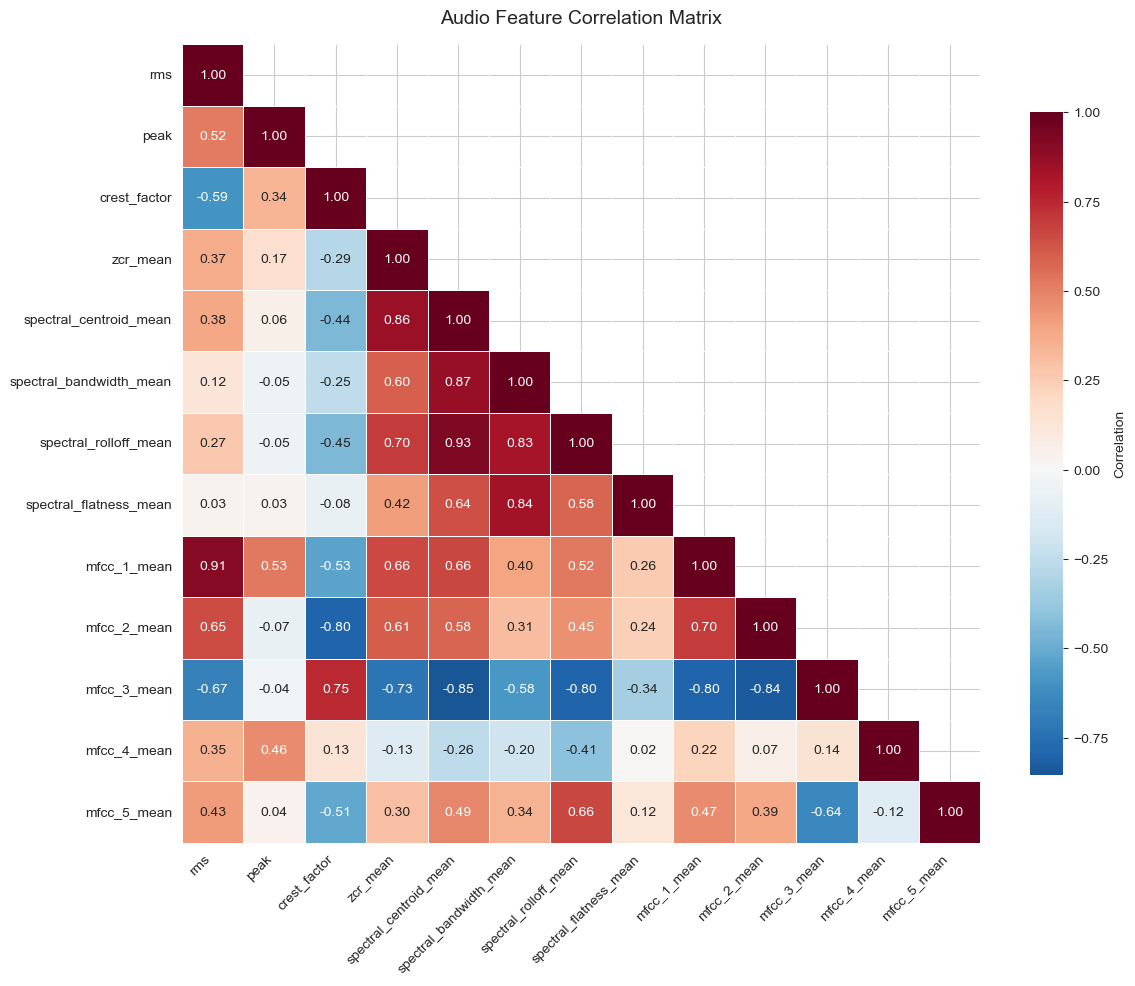

In [20]:
def plot_feature_correlation(features_df: pl.DataFrame):
    """Plot correlation heatmap of audio features."""
    # Select numeric feature columns
    feature_cols = [
        "rms",
        "peak",
        "crest_factor",
        "zcr_mean",
        "spectral_centroid_mean",
        "spectral_bandwidth_mean",
        "spectral_rolloff_mean",
        "spectral_flatness_mean",
    ] + [f"mfcc_{i}_mean" for i in range(1, 6)]  # First 5 MFCCs

    # Filter to existing columns
    existing_cols = [col for col in feature_cols if col in features_df.columns]

    if len(existing_cols) < 2:
        print("Not enough features for correlation analysis")
        return None

    pdf = features_df.select(existing_cols).to_pandas()

    # Compute correlation matrix
    corr_matrix = pdf.corr()

    fig, ax = plt.subplots(figsize=(12, 10))

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap="RdBu_r",
        center=0,
        ax=ax,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8, "label": "Correlation"},
    )

    ax.set_title("Audio Feature Correlation Matrix", fontsize=14, pad=15)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

    return fig


if len(features_df) > 0:
    fig = plot_feature_correlation(features_df)
    plt.show()

## 11. Summary

### Key Sound-Related Features in the Dataset:

1. **NAWSSound**: Near-field acoustic wave sensor measurements - captures close-range tyre noise
2. **mic_iso**: ISO standard pass-by noise measurements - regulatory relevant
3. **SIS Sensors (Ch_1-4_labV12)**: Leading/Trailing edge measurements for tyre deformation sounds

### Analysis Techniques Applied:

1. **Time Domain**: Raw waveform visualization showing amplitude variations
2. **Frequency Spectrum (FFT)**: Identifies dominant frequencies in tyre noise
3. **Spectrogram**: Time-frequency representation showing how noise content evolves
4. **MFCC**: Perceptually-motivated features useful for noise characterization and ML
5. **Mel Spectrogram**: Human hearing-weighted frequency representation
6. **1/3 Octave Bands**: Standard acoustic analysis for regulatory compliance
7. **Feature Correlation**: Understanding relationships between different acoustic measures

### Observations:
- Tyre noise is broadband with energy typically concentrated in 200-2000 Hz range
- Different tyres and vehicles show distinct spectral signatures
- MFCC features capture perceptually relevant differences between measurements
- Spectral features like centroid and bandwidth are useful discriminators